<a href="https://colab.research.google.com/github/Dikshuy/jax-MAML/blob/main/maml_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# -*- coding: utf-8 -*-

!pip install optax

import jax
import jax.numpy as jnp              
import optax                         
import numpy as np                   
import tensorflow_datasets as tfds    
import tensorflow as tf
from jax import grad
from jax import vmap 
from functools import partial
from jax import jit 
from jax.experimental import stax 
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, Softmax, LogSoftmax, AvgPool, BatchNorm
import matplotlib.pyplot as plt 
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import urllib3
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
from tqdm import tqdm


rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# variables
learning_rates = [0.001, 0.005, 0.01]
num_inner_loops = [1,2,3,4,5,6,7]

meta_step_size = 0.001

batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())


    def get_mini_dataset(
        self, shots = shots, num_classes = classes
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        test_labels = np.zeros(shape=(num_classes))
        test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # label to create the test dataset.
            test_labels[class_idx] = class_idx
            images_to_split = random.choices(
                self.data[label_subset[class_idx]], k=shots + 1
            )
            test_images[class_idx] = images_to_split[-1]
            temp_images[
                class_idx * shots : (class_idx + 1) * shots
            ] = images_to_split[:-1]
        
        temp_images, temp_labels = shuffle(temp_images.astype(np.float32), temp_labels.astype(np.int32))
        
        support_set = {'images': temp_images, 'labels': temp_labels}
        query_set = {'images': test_images, 'labels': test_labels}
        
        return support_set, query_set


urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.

losses = []

TRAIN_STEPS = 100

for lr in learning_rates:
  for inner_loop in num_inner_loops:
    maml_losses = []
    for i in tqdm(range(TRAIN_STEPS)):
      train_dataset = Dataset(training=True)
      test_dataset = Dataset(training=False)

      net_init, net_apply = stax.serial(
          Conv(out_chan = 64, filter_shape = (3,3), strides = [1,1], padding = 'SAME'), BatchNorm(), Relu,
          Conv(out_chan = 64, filter_shape = (3,3), strides = [1,1], padding = 'SAME'), BatchNorm(), Relu,
          Conv(out_chan = 64, filter_shape = (3,3), strides = [1,1], padding = 'SAME'), BatchNorm(), Relu,
          Conv(out_chan = 64, filter_shape = (3,3), strides = [1,1], padding = 'SAME'), BatchNorm(), Relu,
          AvgPool((28, 28)),
          Flatten,
          Dense(classes),
      )

      in_shape = (-1, 28, 28, 1)
      out_shape, net_params = net_init(rng, in_shape)

      opt_init, opt_update, get_params = optimizers.adam(step_size=meta_step_size)
      opt_state = opt_init(net_params)

      @jit
      def maml_loss_batch(params, x1_b, y1_b, x2_b, y2_b):
          '''
          input:
          - params
          - x1_b, y1_b, x2_b, y2_b: batches of sample task 
          output:
          - combined loss of the batch
          '''   
          return  onp.mean(vmap(partial(maml_loss, params))(x1_b, y1_b, x2_b, y2_b))

      @jit
      def batch_step(i, opt_state, x1_b, y1_b, x2_b, y2_b):
          p = get_params(opt_state)
          g = grad(maml_loss_batch)(p, x1_b, y1_b, x2_b, y2_b)
          l = maml_loss_batch(p, x1_b, y1_b, x2_b, y2_b)
          return opt_update(i, g, opt_state), l


      @jit
      def loss(params, inputs, targets):
          predictions = net_apply(params, inputs)
          loss_ = jnp.mean(optax.softmax_cross_entropy(predictions, jax.nn.one_hot(targets, num_classes=classes)))
          return loss_

      @jit
      def inner_update(params, inputs, outputs, alpha = lr):
          '''
          input:
          - params: model's parameters
          - inputs
          - targets: true label
          output
          - updated parameters
          '''
          grads = grad(loss)(params, inputs, outputs)
          grad_update_fn = lambda g, state: (state - alpha * g)
          return tree_multimap(grad_update_fn, grads, params)

      @jit
      def maml_loss(params, support_img, support_lab, query_img, query_lab, num_inner_loops=inner_loop):
          '''
          input:
          - params: model's parameters
          - x1, y1: task's train set
          - x2, y2: task's test set
          output:
          - Loss after update parameters 1 time on the test set.
          '''
          params_updated = params
          for _ in range(num_inner_loops):
              params_updated = inner_update(params_updated, support_img, support_lab)
          total_loss = loss(params_updated, query_img, query_lab)
          return total_loss

      # get x_support, y_support, x_query, y_query batch
      x_support_batch = []
      y_support_batch = []
      x_query_batch = []
      y_query_batch = []
      for j in range(batch_size):
          support, query = train_dataset.get_mini_dataset()
          x_support, y_support = support['images'], support['labels']
          x_query, y_query = query['images'], query['labels']
          x_support_batch.append(x_support)
          y_support_batch.append(y_support)
          x_query_batch.append(x_query)
          y_query_batch.append(y_query)
      x_support_batch = np.stack(x_support_batch)
      y_support_batch = np.stack(y_support_batch)
      x_query_batch = np.stack(x_query_batch)
      y_query_batch = np.stack(y_query_batch)
      opt_state, l = batch_step(i, opt_state, x_support_batch, y_support_batch, x_query_batch, y_query_batch)
      maml_losses.append(l)

    net_params = get_params(opt_state)
    # plt.plot(np.arange(TRAIN_STEPS), np.array(maml_losses))
    losses.append(maml_losses)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
100%|██████████| 2/2 [04:13<00:00, 126.60s/it]


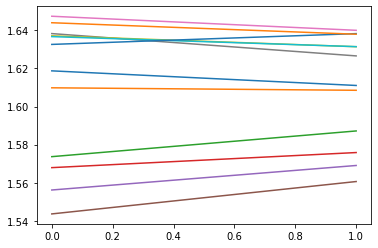

In [16]:
losses
for maml_losses in losses:
  plt.plot(np.arange(100), np.array(maml_losses))
plt.show()